# Convergence of discrete Green operators

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scapin
import scapin.ms94

ModuleNotFoundError: No module named 'scapin'

In [5]:
class ConvergenceTest:
    def __init__(self):
        self.dim = 2
        self.num_refinements = 6
        self.shape_fine = self.dim * (256,)
        self.L = np.array(self.dim * (1.0,))
        self.patch_ratio = self.dim * (0.125,)
        μ = 1.0
        ν = 0.3
        self.hooke = scapin.hooke.Hooke_2c128(μ, ν)
        self.τ_in = np.zeros((self.hooke.isize,), dtype=np.float64)
        self.τ_in[-1] = 1.0
        self.τ_out = np.zeros_like(self.τ_in)

    def create_tau_hat(self, refinement):
        shape = tuple(
            n_ >> (self.num_refinements - 1 - refinement) for n_ in self.shape_fine
        )
        patch_size = tuple(int(r_ * n_) for r_, n_ in zip(self.patch_ratio, shape))

        τ = np.empty(shape + (self.hooke.isize,), dtype=np.complex128)
        τ[...] = self.τ_out
        τ[tuple(slice(n_) for n_ in patch_size) + (...,)] = self.τ_in

        return np.fft.fft2(τ, axes=range(self.dim))

    def run(self, refinement):
        τ_hat = self.create_tau_hat(refinement)
        shape = τ_hat.shape[:-1]
        # TODO Improve on how types are handled
        MoulinecSuquet94 = scapin.ms94.MoulinecSuquet94HookeComplex128_2D
        green_d = MoulinecSuquet94(self.hooke, shape, self.L)
        η_hat = np.empty(shape + (green_d.gamma.osize,), dtype=τ_hat.dtype)
        green_d.apply(τ_hat, η_hat)
        return np.fft.ifft2(η_hat, axes=range(self.dim))

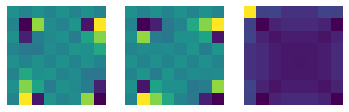

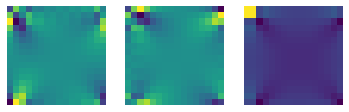

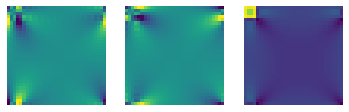

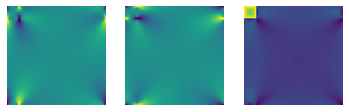

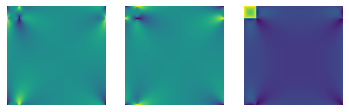

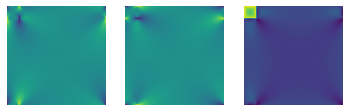

In [6]:
test = ConvergenceTest()
results = []

for r in range(test.num_refinements):
    η = test.run(r)
    results.append(η)
    fig, ax = plt.subplots(1, η.shape[-1])
    for i, ax_i in enumerate(ax):
        ax_i.set_axis_off()
        ax_i.imshow(η[..., i].real)

In [7]:
def auxiliary_shapes(shape_coarse, shape_fine):
    aux_shape_coarse = []
    aux_shape_fine = []

    for i, (nc_i, nf_i) in enumerate(zip(shape_coarse, shape_fine)):
        aux_shape_coarse.append(nc_i)
        aux_shape_coarse.append(1)
        aux_shape_fine.append(nc_i)
        aux_shape_fine.append(nf_i // nc_i)

    return tuple(aux_shape_coarse[:-1]), tuple(aux_shape_fine[:-1])

In [8]:
η_ref = results[-1]
size = []
err = []

for η in results:
    new_shape_coarse, new_shape_fine = auxiliary_shapes(η.shape, η_ref.shape)
    η_zoom = np.empty_like(η_ref)
    η_zoom.reshape(new_shape_fine)[...] = η.reshape(new_shape_coarse)
    size.append(η.shape[0])
    err.append(np.linalg.norm(η_zoom - η_ref))

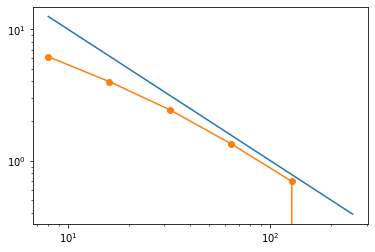

In [9]:
size = np.asarray(size, dtype=np.float64)
err = np.asarray(err, dtype=np.float64)
plt.loglog(size, 100 * size ** -1)
plt.loglog(size, err, "o-")